In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from iminuit import Minuit
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad

First we define some functions that will be used:

In [3]:
def chisq(obs, exp, error):
    return np.sum(np.square(obs - exp) / np.square(error))

In [4]:
def Gauss(E, A, mu, sigma):
    return A * (np.exp(-1/2 * np.square((E - mu) / sigma)) / (sigma * np.sqrt(2*np.pi)))

def Gauss_int(A, mu, sigma, Em, Ep):
    return quad(Gauss, Em, Ep, args=(A, mu, sigma))

Now we define the Multiple broken power law

In [5]:
def multiple_bpl(xdata, params):
    if knots < 2 or knots > 30: #change this when adding more number of knots
        raise Exception('knots have to be larger or equal than 3 and smaller than 30')
    else:
        polw = np.zeros(len(xdata))
        Ebr = np.geomspace(xdata[0], xdata[-1], knots+2)[1:-1]
        gamma = np.zeros(knots+1)
        phi = np.zeros(knots+1)
        phi_0 = params[0] #len(sqrtdelta_lam) = len(lam)-1 = len(phi)-1
        gamma0 = params[1]
        sqrtdelta_gamma = params[2:knots+2]
        delta_gamma = np.square(sqrtdelta_gamma)
        gamma[0] = gamma0
        phi[0] = phi_0
        for i in range(knots):
            gamma[i+1] = gamma[i] + delta_gamma[i]
            phi[i+1] = phi[i] * Ebr[i] ** delta_gamma[i]
        for i in range(len(xdata)):
            for j in range(knots):
                if xdata[i]<Ebr[0]:
                    polw[i] = phi[0] * xdata[i] ** (-gamma[0])
                elif Ebr[-1] < xdata[i]:
                    polw[i] = phi[-1] * xdata[i] ** (-gamma[-1])
                elif Ebr[j] <= xdata[i] < Ebr[j+1]:
                    polw[i] = phi[j+1] * xdata[i] ** (-gamma[j+1])
    return polw

The least squares function for that MBWPL

In [6]:
# least-squares score function = sum of data residuals squared
def LSQ(params):
    return np.sum((ydata - multiple_bpl(xdata, params)) ** 2 / ydata_u ** 2)

And the fit function

In [7]:
def multiple_bpl_fit(initial_guess):
    #print('Warning: the shape of the parametes will depend on the number of knots (defined as knots)')
    #print('Warning: this will give the parameters of the fit and its errors which have to be put into the multiple_bpl function in order to get the fit')
    LSQ.errordef = Minuit.LIKELIHOOD

    m = Minuit(LSQ, initial_guess)
    #m.limits["initial_guess[2:-1]"] = (0,None)
    #m.tol = 1e-30
    m.tol = 1e-20

    m.migrad()
    print(m.values)

    m.hesse()
    print(m.errors)

    return m

Here we will load the Effective area of the telescope and the EBL model file. After that we will also load background rate.

In [8]:
fileEA = np.loadtxt('EffArea50h.txt', skiprows = 11)
EffA = pd.DataFrame(fileEA)
EffA = EffA.rename(columns={ 0 : 'E [TeV]', 1: 'Eff area (m^2)'})
EffaE= EffA['E [TeV]'].to_numpy()
Effa = EffA['Eff area (m^2)'].to_numpy()

#absorption file
file = np.loadtxt('tau_dominguez11.out')
pdfile = pd.DataFrame(file)
pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})
E = pdfile['E [TeV]'].to_numpy()
tau = pdfile['tau z=0.20842105'].to_numpy()

For the background rate we need to do a rebinning to have the same energy bins as with the other data.

In [9]:
fileBkg = np.loadtxt('Bkg50h.txt', skiprows = 10)
Bkgpd = pd.DataFrame(fileBkg)
Bkgpd = Bkgpd.rename(columns={ 0 : 'E_min (TeV)', 1: 'E_max (TeV)', 2: 'Bck Rate (Hz/deg^2)'})

BckgEmin = Bkgpd['E_min (TeV)'].to_numpy()
BckgEmax = Bkgpd['E_max (TeV)'].to_numpy()
Bckg = Bkgpd['Bck Rate (Hz/deg^2)'].to_numpy()
BckgEdiff = BckgEmax - BckgEmin

BckgElogmean = []
for i in range(len(Bckg)):
    BckgElogmean.append(10**(np.mean([np.log10(BckgEmax[i]), np.log10(BckgEmin[i])])))


Ebinsmin = np.zeros(len(E))
Ebinsmax = np.zeros(len(E))

for i in range(1, len(E)):
    Ebinsmin[i] = 10**(np.mean([np.log10(E[i]), np.log10(E[i-1])]))
for i in range(len(E) - 1):
    Ebinsmax[i] = 10**(np.mean([np.log10(E[i]), np.log10(E[i+1])]))
    
Ebinsmin[0] = 10**(np.log10(Ebinsmin[1])-(np.log10(Ebinsmin[2])-np.log10(Ebinsmin[1])))
Ebinsmax[len(E)-1] = 10**(np.log10(Ebinsmax[len(E)-2])-(np.log10(Ebinsmax[len(E)-3])-np.log10(Ebinsmax[len(E)-2])))
Ebinsw = Ebinsmax - Ebinsmin

In [10]:
DifBckg = Bckg / (BckgEmax - BckgEmin) #Hz/deg**2
def log_interp1d(xx, yy):
    logx = np.log10(xx)
    logy = np.log10(yy)
    interp = interpolate.interp1d(logx, logy, fill_value='extrapolate', kind='slinear')
    log_interp = lambda zz: np.power(10.0, interp(np.log10(zz)))
    return log_interp

interpolation = log_interp1d(BckgElogmean,DifBckg)

In [11]:
newBckgrate = np.zeros([len(E[2:37]),2])
for i in range(len(E[2:37])):
    newBckgrate[i] = quad(interpolation, Ebinsmin[i+2], Ebinsmax[i+2])
newBckgrate = newBckgrate[:,0]

After that we create the spectrum of the source and we absorve it with the EBL model loaded before. If you want to change the source spectra, change it here.

In [12]:
#“photon index  = 2.03  +/- 0.03 and normalization factor at 250 GeV    f0 = (8.70 +/- 0.17) * 10^-10 cm^-2  s^-1  TeV^-1.”
K =  8.70e-6 #m−2  s−1  TeV−1
dNdE = K / ((E/0.25)**2.03) 
m_tau = -tau
dNdEa = dNdE * np.exp(m_tau)

We also need to do a rebinning of the effective area

In [13]:
EffaA2 = np.zeros(len(E[2:37]))
for i in range(len(E[2:37])):
    for j in range(len(EffaE[9:51])):
        if EffaE[j+9] < E[i+2] and EffaE[j+10] > E[i+2]:
            m = (Effa[j+10]-Effa[j+9])/(EffaE[j+10]-EffaE[j+9])
            n = Effa[j+9] - m * EffaE[j+9]
            EffaA2[i] = m * E[i+2] + n

And we will also need the angular resolution of the telescope which, of course, will need to be rebinned.

In [14]:
fileAng = np.loadtxt('Angres.txt', skiprows = 11)
Angresall = pd.DataFrame(fileAng)
Angresall = Angresall.rename(columns={ 0 : 'E [TeV]', 1: 'Angular resolution (deg)'})
AngresE= Angresall['E [TeV]'].to_numpy()
Angres = Angresall['Angular resolution (deg)'].to_numpy()

logAngres = np.log10(Angres)
logAngresE = np.log10(AngresE)
logE = np.log10(E)


logAngres2 = np.zeros(len(E[2:37]))
for i in range(len(E[2:37])):
    for j in range(len(AngresE[1:-1])):
        if logAngresE[j+1] < logE[i+2] and logAngresE[j+2] > logE[i+2]:
            m = (logAngres[j+2]-logAngres[j+1])/(logAngresE[j+2]-logAngresE[j+1])
            n = logAngres[j+1] - m * logAngresE[j+1]
            logAngres2[i] = m * logE[i+2] + n
Angres2 = 10**logAngres2

Let's load the Energy resolution and rebin it to fit our data. After that we will get the poisson parameter of the source taking into account the energy resolution.

In [15]:
fileEres = np.loadtxt('Eres.txt', skiprows = 8)
Eresall = pd.DataFrame(fileEres)
Eresall = Eresall.rename(columns={ 0 : 'E [TeV]', 1: 'Energy resolution (deg)'})
EresE = Eresall['E [TeV]'].to_numpy()
Eres = Eresall['Energy resolution (deg)'].to_numpy()

logEres = np.log10(Eres)
logEresE = np.log10(EresE)
logE = np.log10(E)


logEres2 = np.zeros(len(E[2:37]))
for i in range(len(E[2:37])):
    for j in range(len(EresE[0:-1])):
        if logEresE[j] < logE[i+3] and logEresE[j+1] > logE[i+3]:
            m = (logEres[j+1]-logEres[j])/(logEresE[j+1]-logEresE[j])
            n = logEres[j] - m * logEresE[j]
            logEres2[i] = m * logE[i+3] + n
Eres2 = 10**logEres2

Eres3 = np.zeros(len(Eres2))
for i in range(len(Eres2)):
    Eres3[i] = Eres2[i] * E[2:37][i]

In [16]:
def degtorad(ang):
    return ang * np.pi / 180


In [17]:
time = 42480 #42480 #180000#s
skyang = (180/np.pi)**2 * 2 * np.pi * (1-np.cos(degtorad(Angres2)))#deg^2

bckgmu = newBckgrate * time * skyang
mu_vec = dNdEa[2:37] * EffaA2 * Ebinsw[2:37] * time

logEbins = np.zeros(len(E[2:37])+1)
for i in range(len(E[2:37])+1):
    if i == 0:
        logEbins[i] = logE[2] - ((logE[3]-logE[2])/2)
    elif i == (len(E[2:37])):
        logEbins[i] = logE[2:37][i-1] + ((logE[2:37][i-1]-logE[2:37][i-2])/2)
    else:
        logEbins[i] = (logE[2:37][i] + logE[2:37][i-1]) / 2

Ebins = 10 ** logEbins

In [18]:
mu_vec_reco = np.zeros(len(mu_vec))
mu_vec_i = np.zeros(len(mu_vec))

for i in range(len(mu_vec)):
    for j in range(len(mu_vec)):
        A = mu_vec[i]
        B = bckgmu[i]
        Em = Ebins[j]
        Ep = Ebins[j+1]
        sigma = Eres3[i]
        mu = E[2:37][i]

        mu_vec_i[j] = Gauss_int(A, mu, sigma, Em, Ep)[0]
    mu_vec_reco = mu_vec_reco + mu_vec_i

# plt.plot(E[3:37], mu_vec[1:], label="True")
# plt.plot(E[3:37], mu_vec_reco[1:], label="Reconstructed")
# plt.xscale("log")
# plt.legend()
# plt.show()

Now we generate 2 random samples of the background. The first one is the background contribution to the observations and the other one is the observed background in 5 wobbles that we will use to reduce the background noise. After that we also simulate the source spectra. Those 3 things are made using a Poisson disteibution.Then we sum the 3 contributions and we take the number of photons to SED. 

In [19]:
my_generator = np.random.default_rng(2021)
Simbckg1 = my_generator.poisson(bckgmu)
# Simbckg1 = Simbckg1.astype(float)
# for i in range(len(Simbckg1)):
#     if Simbckg1[i] == 0:
#         Simbckg1[i] = bckgmu[i]
Simbckg1_u = np.sqrt(Simbckg1)
Simbckg5 = my_generator.poisson(5*bckgmu)/5
# Simbckg5 = Simbckg5.astype(float)
# for i in range(len(Simbckg5)):
#     if Simbckg5[i] == 0:
#         Simbckg5[i] = bckgmu[i]
Simbckg5_u = np.sqrt(Simbckg5)

N = my_generator.poisson(mu_vec_reco)
# N = mu

# for i in range(len(N)):
#     if N[i] == 0:
#         N[i] = mu[i]
N_u = np.sqrt(N)

NpB = np.around(N + Simbckg1 - Simbckg5).astype(int)
NpB_u = N_u + Simbckg1_u - Simbckg5_u

In [20]:
dNdE_b = NpB[1:] / EffaA2[1:35] / Ebinsw[3:37] / time
dNdE_b_u = NpB_u[1:] / EffaA2[1:35] / Ebinsw[3:37] / time

In [21]:
SED = np.square(E[3:37]) * dNdE_b
SED_u = np.square(E[3:37]) * dNdE_b_u

We plot the obtained spectra

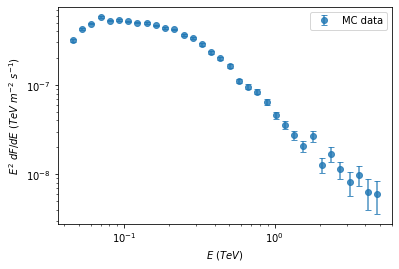

In [22]:
plt.errorbar(E[3:37], SED, label='MC data',yerr = SED_u, capsize=3, fmt='o', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$E$ ($TeV$)")
plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
plt.legend()
plt.show()

Okay, now let's use the new fitting method:

<ValueView x0=1.7993340569023153e-06 x1=-0.5000872167874816 x2=-0.9412974885117453 x3=-0.8203472548078293 x4=-0.8124598969053288 x5=-1.1320585395785279e-07 x6=0.0>
<ErrorView x0=9.849791681626788e-08 x1=0.02104997708317041 x2=0.018533150475448002 x3=0.023546376938222365 x4=0.030561401233628913 x5=0.12670268882605812 x6=0.21055226119153714>


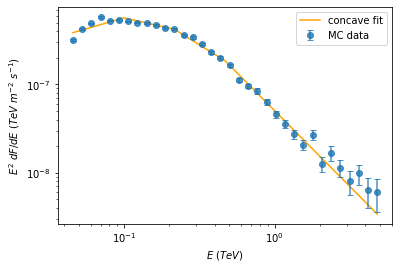

In [23]:
ydata = SED
xdata = E[3:37]
knots = 5
ydata_u = SED_u
initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
things = multiple_bpl_fit(initial_guess=initial_guess)

Egam = np.geomspace(E[3],E[36], 300)

plt.plot(Egam, multiple_bpl(Egam, things.values), label='concave fit', color = 'orange')
plt.errorbar(xdata, ydata, label='MC data',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$E$ ($TeV$)")
plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
plt.legend()
plt.show()

Finally we use this SED and deabsorb the EBL while fitting the MBPWL to every value of $\alpha$ and get its corresponding $\chi^2$ value.

<ValueView x0=3.3580626401535595e-07 x1=0.18848931937007474 x2=-1.1093973258530032 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=3.4425817459419725e-07 x1=0.1789785545024471 x2=-1.082263367441554 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=3.270861499441414e-07 x1=0.20349694626966722 x2=-0.9704101312572888 x3=-0.6486657460182239 x4=-1.2026526521995924e-07 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=3.617200915947131e-07 x1=0.16006073123862719 x2=-1.0258544559468112 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=3.456980347672509e-07 x1=0.181

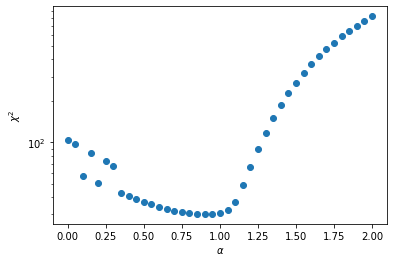

In [24]:
chisqs = []
alphas = np.arange(0,2.05,0.05)

for i in range(len(alphas)):
    alpha = alphas[i]
    dNdE2 = dNdE_b[4:] * np.exp(alpha*tau[7:37])
    dNdE2_u = dNdE_b_u[4:] * np.exp(alpha*tau[7:37])
    SED2 = np.square(E[7:37]) * dNdE2
    SED_u2 = np.square(E[7:37]) * dNdE2_u
    ydata = SED2
    xdata = E[7:37]
    knots = 3
    ydata_u = SED_u2
    initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
    things = multiple_bpl_fit(initial_guess=initial_guess)
    chi2 = chisq(SED2, multiple_bpl(E[7:37], things.values), SED_u2)
    chisqs.append(chi2)

    # if alpha == 0.1 or alpha == 0.15 or alpha == 0.9 or alpha == 1.:  #This is used to plot the data+ the fit when there is some alpha value we need to see.
    #     plt.plot(xdata, multiple_bpl(xdata, things.values), label='concave fit', color = 'orange')
    #     plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
    #     plt.xscale('log')
    #     plt.yscale('log')
    #     plt.xlabel(r"$E$ ($TeV$)")
    #     plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
    #     plt.legend()
    #     plt.show()

plt.plot(alphas, chisqs, 'o')
plt.yscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\chi^2$')
plt.show()

Now we will repeat that but making a zoom between 0.76 and 1.14

<ValueView x0=4.6753711247834023e-07 x1=0.06453671903340742 x2=-0.5192271914703013 x3=-0.4115515778533763 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=4.726631811696761e-07 x1=0.06029810448640484 x2=-0.49893059961365477 x3=-0.40240992386467206 x4=1.1919170807293103e-06 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=4.778432202931874e-07 x1=0.05606138723764709 x2=-0.47777458185979566 x3=-0.3930747287794208 x4=-1.3625516951703316e-06 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=4.83077614292851e-07 x1=0.05182680512038928 x2=-0.4556391854906349 x3=-0.38353150312813583 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=

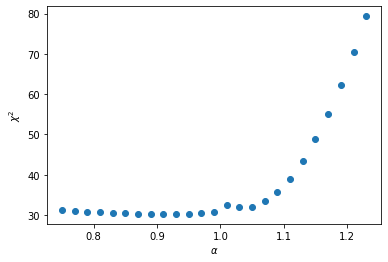

In [25]:
chisqs = []
alphas = np.arange(0.75,1.25,0.02)

for i in range(len(alphas)):
    alpha = alphas[i]
    dNdE2 = dNdE_b[4:] * np.exp(alpha*tau[7:37])
    dNdE2_u = dNdE_b_u[4:] * np.exp(alpha*tau[7:37])
    SED2 = np.square(E[7:37]) * dNdE2
    SED_u2 = np.square(E[7:37]) * dNdE2_u
    ydata = SED2
    xdata = E[7:37]
    knots = 3
    ydata_u = SED_u2
    initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
    things = multiple_bpl_fit(initial_guess=initial_guess)
    chi2 = chisq(SED2, multiple_bpl(E[7:37], things.values), SED_u2)
    chisqs.append(chi2)

    # if alpha == 0.1 or alpha == 0.15 or alpha == 0.9 or alpha == 1.:  #This is used to plot the data+ the fit when there is some alpha value we need to see.
    #     plt.plot(xdata, multiple_bpl(xdata, things.values), label='concave fit', color = 'orange')
    #     plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
    #     plt.xscale('log')
    #     plt.yscale('log')
    #     plt.xlabel(r"$E$ ($TeV$)")
    #     plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
    #     plt.legend()
    #     plt.show()
plt.plot(alphas, chisqs, 'o')
#plt.yscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\chi^2$')
plt.show()

alpha =  0
<ValueView x0=3.1406718613112394e-07 x1=0.22051725752335768 x2=1.073383948852383 x3=0.0 x4=0.0>
<ErrorView x0=7.930286270854555e-09 x1=0.01266829757512844 x2=0.009523942572077332 x3=1.4144819583327357 x4=0.06508095844765645>


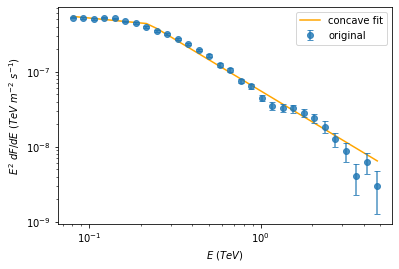

In [26]:
my_generator = np.random.default_rng(9)
Simbckg1 = my_generator.poisson(bckgmu)
# Simbckg1 = Simbckg1.astype(float)
# for i in range(len(Simbckg1)):
#     if Simbckg1[i] == 0:
#         Simbckg1[i] = bckgmu[i]
Simbckg1_u = np.sqrt(Simbckg1)
Simbckg5 = my_generator.poisson(5*bckgmu)/5
# Simbckg5 = Simbckg5.astype(float)
# for i in range(len(Simbckg5)):
#     if Simbckg5[i] == 0:
#         Simbckg5[i] = bckgmu[i]
Simbckg5_u = np.sqrt(Simbckg5)

N = my_generator.poisson(mu_vec_reco)

for i in range(len(N)): #this is used to avoid crashing when dividing by 0.
    if N[i] == 0:
        N[i] = 1
N_u = np.sqrt(N)

NpB = np.around(N + Simbckg1 - Simbckg5).astype(int)
NpB_u = N_u + Simbckg1_u - Simbckg5_u

dNdE_b = NpB[1:] / EffaA2[1:35] / Ebinsw[3:37] / time  #not strictly correct after energy migration
dNdE_b_u = NpB_u[1:] / EffaA2[1:35] / Ebinsw[3:37] / time

SED = np.square(E[3:37]) * dNdE_b
SED_u = np.square(E[3:37]) * dNdE_b_u

chisqs = []
alphas = np.arange(0,2.05,0.05) #if you want to change the alpha values


alpha = 0
print("alpha = ", alpha)
dNdE2 = dNdE_b[4:] * np.exp(alpha*tau[7:37])
dNdE2_u = dNdE_b_u[4:] * np.exp(alpha*tau[7:37])
SED2 = np.square(E[7:37]) * dNdE2
SED_u2 = np.square(E[7:37]) * dNdE2_u
ydata = SED2
xdata = E[7:37]
knots = 3
ydata_u = SED_u2
initial_guess = np.array([5e-7, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots))
things = multiple_bpl_fit(initial_guess=initial_guess)
chi2 = chisq(SED2, multiple_bpl(E[7:37], things.values), SED_u2)

plt.plot(xdata, multiple_bpl(xdata, things.values), label='concave fit', color = 'orange')
plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$E$ ($TeV$)")
plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
plt.legend()
plt.show() 

<ValueView x0=5.244120277901452e-07 x1=0.020740467688220923 x2=0.0 x3=0.0 x4=0.0>
<ErrorView x0=6.786882772693187e-09 x1=0.007005435368103961 x2=1.4158228566319144 x3=0.12049175026572706 x4=0.11307420741761837>
alpha =  1.05
<ValueView x0=5.69735159800532e-07 x1=-0.016983303140318057 x2=0.0 x3=0.0 x4=0.0>
<ErrorView x0=7.538809277051276e-09 x1=0.00718544689139771 x2=0.08540724647223395 x3=0.10571712961692391 x4=0.22216701341332923>
alpha =  1.1
<ValueView x0=6.178396105990031e-07 x1=-0.053858943203316426 x2=0.0 x3=0.0 x4=0.0>
<ErrorView x0=8.359029343723856e-09 x1=0.007365426884165271 x2=0.05493469753935641 x3=0.07694751575794843 x4=0.18450360326011164>
alpha =  1.1500000000000001
<ValueView x0=6.687665030479791e-07 x1=-0.08986789792829751 x2=0.0 x3=0.0 x4=0.0>
<ErrorView x0=9.253254483094353e-09 x1=0.007549618569803394 x2=0.04410664676908001 x3=0.06478851131999515 x4=0.16517839733323667>
alpha =  1.2000000000000002
<ValueView x0=7.225459183438472e-07 x1=-0.12499506939414017 x2=0.0 x3=

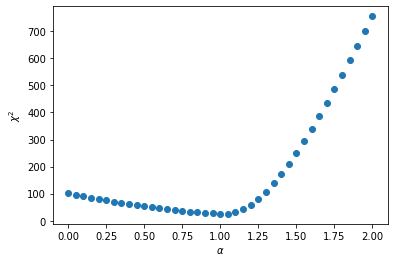

In [29]:
my_generator = np.random.default_rng(6)
Simbckg1 = my_generator.poisson(bckgmu)
# Simbckg1 = Simbckg1.astype(float)
# for i in range(len(Simbckg1)):
#     if Simbckg1[i] == 0:
#         Simbckg1[i] = bckgmu[i]
Simbckg1_u = np.sqrt(Simbckg1)
Simbckg5 = my_generator.poisson(5*bckgmu)/5
# Simbckg5 = Simbckg5.astype(float)
# for i in range(len(Simbckg5)):
#     if Simbckg5[i] == 0:
#         Simbckg5[i] = bckgmu[i]
Simbckg5_u = np.sqrt(Simbckg5)

N = my_generator.poisson(mu_vec_reco)

for i in range(len(N)): #this is used to avoid crashing when dividing by 0.
    if N[i] == 0:
        N[i] = 1
N_u = np.sqrt(N)

NpB = np.around(N + Simbckg1 - Simbckg5).astype(int)
NpB_u = N_u + Simbckg1_u - Simbckg5_u

dNdE_b = NpB[1:] / EffaA2[1:35] / Ebinsw[3:37] / time  #not strictly correct after energy migration
dNdE_b_u = NpB_u[1:] / EffaA2[1:35] / Ebinsw[3:37] / time

SED = np.square(E[3:37]) * dNdE_b
SED_u = np.square(E[3:37]) * dNdE_b_u

chisqs = []
# alphas = np.arange(0,2.05,0.05) #if you want to change the alpha values
alphas1 = np.arange(1.05,2.05,0.05)
alphas2 = np.arange(1, -0.05, -0.05)
alphas = np.append(alphas1, alphas2)

alpha = 1
dNdE2 = dNdE_b[4:] * np.exp(alpha*tau[7:37])
dNdE2_u = dNdE_b_u[4:] * np.exp(alpha*tau[7:37])
SED2 = np.square(E[7:37]) * dNdE2
SED_u2 = np.square(E[7:37]) * dNdE2_u
ydata = SED2
xdata = E[7:37]
knots = 3
ydata_u = SED_u2
initial_guess = np.array([5e-7, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots))
things = multiple_bpl_fit(initial_guess=initial_guess)


initial_guess_mat = np.zeros((len(alphas)+1, 5))
initial_guess_mat[0] = things.values #phi_0, lam1, deltas (len(deltas)=knots))

for i in range(len(alphas)):
    alpha = alphas[i]
    print("alpha = ", alpha)
    dNdE2 = dNdE_b[4:] * np.exp(alpha*tau[7:37])
    dNdE2_u = dNdE_b_u[4:] * np.exp(alpha*tau[7:37])
    SED2 = np.square(E[7:37]) * dNdE2
    SED_u2 = np.square(E[7:37]) * dNdE2_u
    ydata = SED2
    xdata = E[7:37]
    knots = 3
    ydata_u = SED_u2
    # initial_guess = np.array([5e-7, 0, 0, 0, 0])
    initial_guess = initial_guess_mat[i] 
    if alpha == 1.:
        initial_guess = initial_guess_mat [0]
    things = multiple_bpl_fit(initial_guess=initial_guess)
    if i < (len(alphas)):
        initial_guess_mat[i+1] = things.values
    chi2 = chisq(SED2, multiple_bpl(E[7:37], things.values), SED_u2)
    chisqs.append(chi2)

plt.plot(alphas, chisqs, 'o')
#plt.yscale('log')
# plt.xlim(0.75,1.15)
# plt.ylim(30,40)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\chi^2$')
plt.show()
